# Gathering and plotting images that were modified during the relabeling process, 
(for paper referee)

May 2, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import subprocess as sp
import pickle
import ipywidgets as widgets
import time
from matplotlib.colors import LogNorm, PowerNorm, Normalize

import glob

In [2]:
%matplotlib widget

## Relabelling details

In [3]:
fname='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/gathered_data/relabeled_autoscan_features.csv'
df_full=pd.read_csv(fname,sep=',',comment='#')
df_full.head()

,ID,OBJECT_TYPE,AMP,A_IMAGE,A_REF,BAND,B_IMAGE,B_REF,CCDID,COLMEDS,...,N3SIG5,N3SIG5SHIFT,NN_DIST_RENORM,NUMNEGRN,SCALE,SNR,SPREADERR_MODEL,SPREAD_MODEL,old_OBJECT_TYPE,check_relabel
0,10742010,0,0.808323,1.508,2.650069,i,0.950,1.899501,10,0.112077,...,0,-9,0.674934,22,2.024122,7.722346,0.004629,-0.003718,0,False
1,8828139,0,0.975141,1.430,NaN,i,1.319,NaN,10,0.072256,...,0,5,NaN,21,1.379283,25.582918,0.002420,-0.000578,0,False
2,8229889,0,0.877440,0.505,NaN,z,0.494,NaN,57,0.106124,...,0,1,NaN,20,0.950069,3.914192,0.008863,-0.020044,0,False
3,11033218,0,0.681179,0.762,3.008957,i,0.449,2.855881,1,0.139071,...,2,-27,1.240574,18,1.749488,5.068382,0.008041,0.000246,0,False
4,8341858,0,0.645906,1.205,1.352224,i,0.982,1.063333,30,0.123302,...,0,4,2.970234,16,1.930613,7.372579,0.005606,0.001771,0,False


In [4]:
print(df_full.columns)

Index(['ID', 'OBJECT_TYPE', 'AMP', 'A_IMAGE', 'A_REF', 'BAND', 'B_IMAGE',
       'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN', 'ELLIPTICITY', 'FLAGS',
       'FLUX_RATIO', 'GAUSS', 'GFLUX', 'L1', 'LACOSMIC', 'MAG', 'MAGDIFF',
       'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF', 'MAG_REF_ERR', 'MASKFRAC',
       'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3', 'N2SIG3SHIFT', 'N2SIG5',
       'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT', 'N3SIG5', 'N3SIG5SHIFT',
       'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR', 'SPREADERR_MODEL',
       'SPREAD_MODEL', 'old_OBJECT_TYPE', 'check_relabel'],
      dtype='object')


In [5]:
checked=df_full[df_full.check_relabel==True].shape[0]
total=df_full.shape[0]
changed= df_full[df_full.OBJECT_TYPE!=df_full.old_OBJECT_TYPE].shape[0]

In [6]:
print(checked, changed, total) 
print("% Checked",(checked/total)*100)
print("% Changed",(changed/total)*100)
print("% of checked that changed",(changed/checked)*100)



8093 7402 898963
% Checked 0.9002595212483717
% Changed 0.8233931763598724
% of checked that changed 91.46175707401459


In [7]:
df2=pd.read_csv('../5_relabelling_data/fulldataset_relabeling_results_duplicate.csv')
display(df2.head())
print(df2[df2.old_label!=df2.final_label].shape,df2.shape)

,ID,old_label,changed_label,final_label
0,8809567,1,0,1
1,8811073,1,0,0
2,7012253,1,0,1
3,10699160,1,0,0
4,9237522,1,0,0


(7402, 4) (8093, 4)


## Extracting images that changed labels

In [8]:
def f_plot_grid(arr,labels,rows=3,cols=16,fig_size=(15,5),title='title'):
    ''' Plot a grid of images
    '''
    size=arr.shape[0]    
    fig,axarr=plt.subplots(rows,cols,figsize=fig_size, gridspec_kw = {'wspace':0, 'hspace':0.0})
    if rows==1: axarr=np.reshape(axarr,(rows,cols))
    if cols==1: axarr=np.reshape(axarr,(rows,cols))
    
    for i in range(rows):
        for j in range(cols):
            # print(i,j)
            # axarr[i,j].title(labels[j])
            try:
                axarr[i,j].imshow(arr[i,j],origin='lower', cmap='inferno', extent = [0, 51, 0, 51])
                # axarr[i,j].imshow(arr[i,j],origin='lower', cmap='inferno', extent = [0, 51, 0, 51], norm=Normalize(vmin=-1., vmax=1.))
            # Drop axis label
            except Exception as e:
                print('Exception:',e)
                pass
            # temp=plt.setp([a.get_xticklabels() for a in axarr[:-1,:].flatten()], visible=False)
            # temp=plt.setp([a.get_yticklabels() for a in axarr[:,1:].flatten()], visible=False)
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_xticklabels([])
            
    for j in range(3): 
        axarr[0,j].set_title(labels[j])
        
    fig.suptitle(title)
    plt.show()
    
    
# def f_extract_imgs_index(df,idlist):
#     ''' Module to extract all 3 types of files for a certain set of IDs
#     '''
# #     assert ID<df.shape[0],"Index %s must be in Dataframe of size %s"%(ID,df.shape[0])
#     img_lst=[]
    
#     for ID in idlist: 
#         df2=df[df.ID==ID].reset_index(drop=True)
#         # display(df2)
#         labels=[ftype[:4] for ftype in df2.filename.values]

#         img_lst.append([plt.imread(fle) for fle in df2['file path']])
#     return np.array(img_lst),labels


def f_extract_imgs_index(df,idlist):
    ''' Module to extract all 3 types of files for a certain set of IDs
    '''
#     assert ID<df.shape[0],"Index %s must be in Dataframe of size %s"%(ID,df.shape[0])
    img_lst=[]
    
    for ID in idlist: 
        df2=df[df.ID==ID].reset_index(drop=True)
        # display(df2)        
        fle_lst=[]
        for label in ['temp','srch','diff']: # Need to extract in the right order
            df3=df2[df2.filename==label+str(ID)+'.gif']
            # display(df3)
            # Creat list of files in the right order
            fle_lst.append(df3['file path'].values[0])
        # print(fle_lst)
        img_lst.append([plt.imread(fle) for fle in fle_lst])
    return np.array(img_lst)

In [9]:
df_changed=df_full[df_full.OBJECT_TYPE!=df_full.old_OBJECT_TYPE][['ID','OBJECT_TYPE','old_OBJECT_TYPE']]

In [10]:
# 0 -> 1 Non-artifacts changed to artifacts
id1=df_changed[df_changed.old_OBJECT_TYPE==0].ID.values
# 1 -> 0 Artifacts changed to non-artifacts
id2=df_changed[df_changed.old_OBJECT_TYPE==1].ID.values
print(id1.shape,id2.shape)

(5636,) (1766,)


In [11]:
fname1='/global/project/projectdirs/dasrepo/vpa/supernova_cnn/data/gathered_data/summary_label_files.csv'
df1=pd.read_csv(fname1,sep=',',comment='#')
print(df1.shape)

(2696889, 4)


In [12]:
df1.head()

,ID,filename,file path,Label
0,801292,srch801292.gif,/global/project/projectdirs/dasrepo/vpa/supern...,1
1,801292,temp801292.gif,/global/project/projectdirs/dasrepo/vpa/supern...,1
2,801292,diff801292.gif,/global/project/projectdirs/dasrepo/vpa/supern...,1
3,800911,temp800911.gif,/global/project/projectdirs/dasrepo/vpa/supern...,1
4,800911,diff800911.gif,/global/project/projectdirs/dasrepo/vpa/supern...,1


In [13]:
df1.shape

(2696889, 4)

In [14]:
# fig=plt.figure(figsize=(3,10))
# num_imgs=8

# for i in range(num_imgs):
#     for j in range(3):
#         idx=i*3+(j+1)
#         fig.add_subplot(num_imgs,3,idx)
#         plt.imshow(img_arr[i][j],origin='lower', cmap='inferno', extent = [0, 51, 0, 51])
#         if i==0 :  plt.title(labels[j])
#         plt.setp(plt.gcf().get_axes(),xticks=[],yticks=[])
        
# fig.tight_layout(h_pad=0.5, w_pad=2.0)
# plt.show()

In [15]:
labels=['temp','srch','diff']
dict1={'temp':'Template', 'srch': 'Search', 'diff': 'Difference'}
labels_lst=[dict1[l] for l in labels]
labels_lst

['Template', 'Search', 'Difference']

### Incorrectly labeled Non-Artifacts

In [16]:
### Get image array and labels for the 3 types
num_images=100
# ID=id1[:num_images]
ID=np.random.choice(id1,size=num_images,replace=False)
img_arr=f_extract_imgs_index(df1,ID)
print(img_arr.shape,labels)

(100, 3, 51, 51) ['temp', 'srch', 'diff']


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
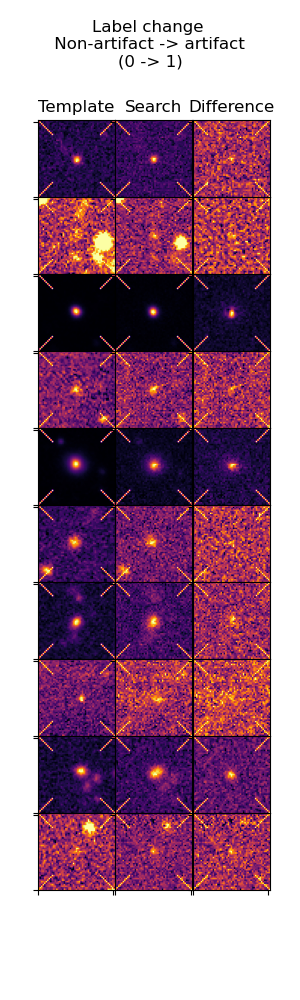

In [22]:
f_plot_grid(img_arr,labels_lst,10,3,(3,10),'Label change \n Non-artifact -> artifact \n(0 -> 1)')
plt.savefig('false0.pdf')

### Incorrectly labeled Artifacts

In [18]:
### Get image array and labels for the 3 types
num_images=100
# ID=id2[:num_images]
ID=np.random.choice(id2,size=num_images,replace=False)
img_arr=f_extract_imgs_index(df1,ID)
print(img_arr.shape,labels)

(100, 3, 51, 51) ['temp', 'srch', 'diff']


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
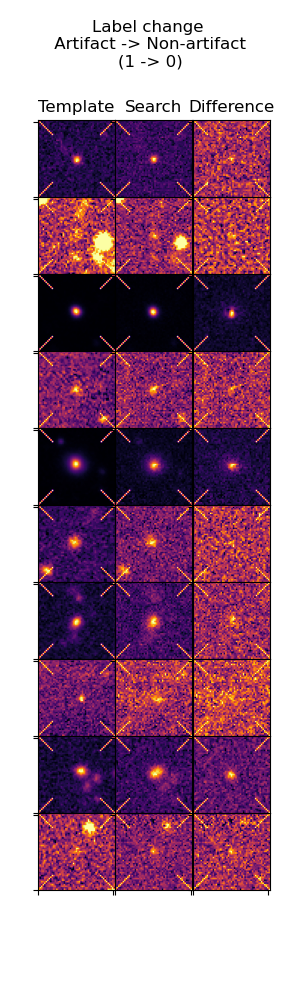

In [19]:
f_plot_grid(img_arr,labels_lst,10,3,(3,10),'Label change \n Artifact -> Non-artifact \n(1 -> 0)')
plt.savefig('false1.pdf')